# Example with a complex mesh in 3d

In [130]:
# input data
size = Lx, Ly, Lz = (20, 2, 2)
F = -10  # value of the load at the free end
E = 12000.  # Young's mpdulus
nu = 0.2  # Poisson's ratio
R = 0.05  # radius of the circular beam CS
t = 0.05  # thickness of the shells

# grid params
resolution = (80, 8, 8)

# oc parameters
volume_fraction = 0.3
ftol = 0.9
nIter = 250
rmax = 0.5,
k = 12


In [131]:
from sigmaepsilon.solid.material import MindlinShell
import numpy as np

# material for solids
HookeH8 = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))

# material for beams
G = E / (2 * (1 + nu))
A = np.pi * R**2
Iy = Iz = 0.25 * np.pi * R**4
Ix = 0.5 * np.pi * R**4
HookeB2 = np.array([
    [E*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, E*Iy, 0],
    [0, 0, 0, E*Iz]
])

# material for shells
shell_data = {
    '0': {
        'hooke': MindlinShell.Hooke(E=E, nu=nu),
        'angle': 0.,
        'thickness': t
    },
}
HookeQ4 = MindlinShell.from_dict(shell_data).elastic_stiffness_matrix()


In [132]:
from neumann import repeat, minmax
from polymesh.space import PointCloud, StandardFrame
from polymesh.grid import gridH8 as grid
from polymesh.utils.topology import H8_to_L2, H8_to_Q4
from polymesh.utils import cell_centers_bulk
from polymesh.utils.space import frames_of_lines, frames_of_surfaces
from sigmaepsilon.solid import Structure, PointData, FemMesh
from sigmaepsilon.solid.fem.cells import H8, B2, Q4_S_MR as Q4

# generate grid
gridparams = {
    'size': size,
    'shape': resolution,
    'origo': (0, 0, 0),
    'start': 0
}
coords, topo = grid(**gridparams)

# place the origo to the center of the cross section
# at the support
pc = PointCloud(coords)
pc.centralize()
dx = pc.bounds()[0, 0]
pc.move(np.array([-dx, 0., 0.]))
coords = pc.show()

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, 0, 0)
iF = pc.index_of_closest([Lx, 0., 0.])
loads = np.zeros((coords.shape[0], 6))
loads[iF, 2] = F

# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
centers = cell_centers_bulk(coords, topo)
condH8 = centers[:, 0] < (Lx/3)
condQ4 = (centers[:, 0] >= (Lx/3)) & (centers[:, 0] < (2*Lx/3))
condB2 = centers[:, 0] >= (2*Lx/3)
topoH8 = topo[condH8]
_, topoQ4 = H8_to_Q4(coords, topo[condQ4])
_, topoB2 = H8_to_L2(coords, topo[condB2])
framesH8 = repeat(GlobalFrame.show(), topoH8.shape[0])
cdH8 = H8(topo=topoH8, frames=framesH8, material=HookeH8)
framesQ4 = frames_of_surfaces(coords, topoQ4)
cdQ4 = Q4(topo=topoQ4, frames=framesQ4, material=HookeQ4, t=t)
framesB2 = frames_of_lines(coords, topoB2)
cdB2 = B2(topo=topoB2, frames=framesB2, material=HookeB2, areas=A)

# set up mesh and structure
mesh = FemMesh(pd, frame=GlobalFrame)
mesh['H8'] = FemMesh(cdH8)
mesh['Q4'] = FemMesh(cdQ4)
mesh['B2'] = FemMesh(cdB2)
structure = Structure(mesh=mesh)


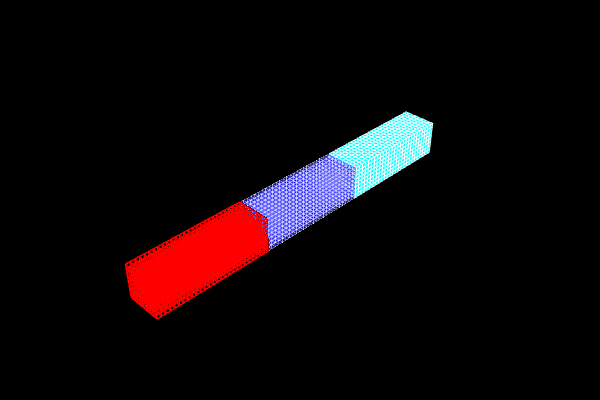

In [133]:
import pyvista as pv
from pyvista import themes

my_theme = themes.DarkTheme()
my_theme.lighting = False
my_theme.show_edges = True
my_theme.axes.box = True

mesh['B2'].config['pyvista', 'plot', 'color'] = 'red'
mesh['B2'].config['pyvista', 'plot', 'line_width'] = 1.5
mesh['B2'].config['pyvista', 'plot', 'render_lines_as_tubes'] = True

mesh['Q4'].config['pyvista', 'plot', 'show_edges'] = True
mesh['Q4'].config['pyvista', 'plot', 'color'] = 'blue'
mesh['Q4'].config['pyvista', 'plot', 'opacity'] = 0.3

mesh['H8'].config['pyvista', 'plot', 'show_edges'] = True
mesh['H8'].config['pyvista', 'plot', 'color'] = 'cyan'
mesh['H8'].config['pyvista', 'plot', 'opacity'] = 1.0

mesh.pvplot(notebook=True, jupyter_backend='static', theme=my_theme,
            window_size=(600, 400), config_key=('pyvista', 'plot'))


In [134]:
np.max(mesh.element_dof_numbering())

39365

In [135]:
# solve
structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()
structure.mesh.pd['x'] = coords + dofsol[:, :3]


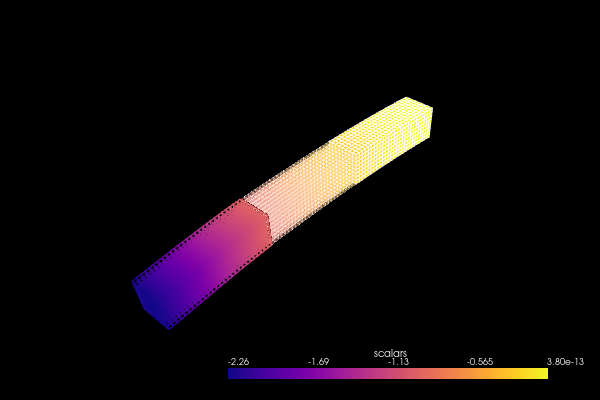

In [136]:
# plot
mesh.pvplot(notebook=True, window_size=(600, 400), cmap='plasma',
            config_key=('pyvista', 'plot'),
            theme=my_theme, jupyter_backend='static', scalars=dofsol[:, 2])


## Optimize

In [137]:
from sigmaepsilon.solid.topopt.oc import maximize_stiffness
from linkeddeepdict import LinkedDeepDict
from tqdm import tqdm

history = LinkedDeepDict(dict(vol=[], obj=[], pen=[], x=[]))

knn = structure.mesh.k_nearest_cell_neighbours(k)

In [138]:
# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_inc': 0.0,
    'q': 0.5,  # smoothing factor
    'vfrac': volume_fraction,
    'dtol': 0.3,  # to control maximum change in the variables
    'miniter': 30,
    'maxiter': 1e12,
    'rmax' : rmax
}
if rmax is None:
    OC_params['neighbours'] = knn
optimizer = maximize_stiffness(structure, **OC_params)
r = next(optimizer)
history['obj'].append(r.obj)
history['vol'].append(r.vol)
history['pen'].append(r.pen)

In [139]:
for _ in tqdm(range(10)):
    r = next(optimizer)
    history['obj'].append(r.obj)
    history['vol'].append(r.vol)
    history['pen'].append(r.pen)

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


In [140]:
# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 3.0,
    'p_inc': 0.2,
    'p_step': 5,
    'q': 0.5,  # smoothing factor
    'vfrac': volume_fraction,
    'dtol': 0.1,  # to control maximum change in the variables
    'miniter': 30,
    'maxiter': 1e12,
    'rmax' : rmax,
}
if rmax is None:
    OC_params['neighbours'] = knn
optimizer = maximize_stiffness(structure, guess=r.x, i_start=r.n + 1, **OC_params)
for _ in tqdm(range(nIter)):
    r = next(optimizer)
    history['obj'].append(r.obj)
    history['vol'].append(r.vol)
    history['pen'].append(r.pen)

100%|██████████| 250/250 [05:02<00:00,  1.21s/it]


## Postproc

In [141]:
iB2 = mesh['B2'].cell_indices()
topoB2 = topoB2[np.where(r.x[iB2] >= ftol)[0]]

iH8 = mesh['H8'].cell_indices()
topoH8 = topoH8[np.where(r.x[iH8] >= ftol)[0]]

iQ4 = mesh['Q4'].cell_indices()
topoQ4 = topoQ4[np.where(r.x[iQ4] >= ftol)[0]]

In [142]:
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, 0, 0)
iF = pc.index_of_closest([Lx, 0., 0.])
loads = np.zeros((coords.shape[0], 6))
loads[iF, 2] = F

# pointdata
GlobalFrame = StandardFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
framesH8 = repeat(GlobalFrame.show(), topoH8.shape[0])
cdH8 = H8(topo=topoH8, frames=framesH8, material=HookeH8)
framesQ4 = frames_of_surfaces(coords, topoQ4)
cdQ4 = Q4(topo=topoQ4, frames=framesQ4, material=HookeQ4, t=t)
framesB2 = frames_of_lines(coords, topoB2)
cdB2 = B2(topo=topoB2, frames=framesB2, material=HookeB2, areas=A)

# set up mesh and structure
mesh = FemMesh(pd, frame=GlobalFrame)
mesh['H8'] = FemMesh(cdH8)
mesh['Q4'] = FemMesh(cdQ4)
mesh['B2'] = FemMesh(cdB2)
mesh.nummrg()

structure = Structure(mesh=mesh)

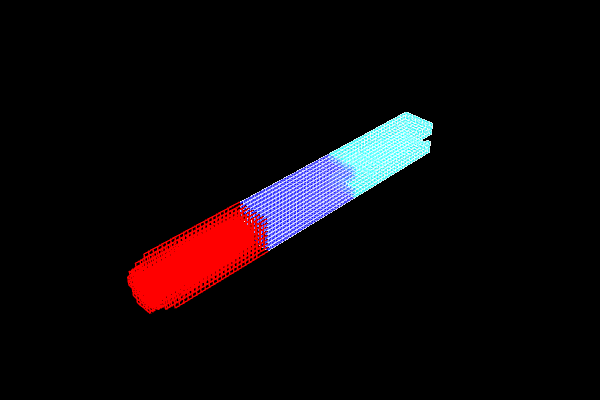

In [143]:
mesh['B2'].config['pyvista', 'plot', 'color'] = 'red'
mesh['B2'].config['pyvista', 'plot', 'line_width'] = 1.5
mesh['B2'].config['pyvista', 'plot', 'render_lines_as_tubes'] = True

mesh['Q4'].config['pyvista', 'plot', 'show_edges'] = True
mesh['Q4'].config['pyvista', 'plot', 'color'] = 'blue'
mesh['Q4'].config['pyvista', 'plot', 'opacity'] = 0.8

mesh['H8'].config['pyvista', 'plot', 'show_edges'] = True
mesh['H8'].config['pyvista', 'plot', 'color'] = 'cyan'
mesh['H8'].config['pyvista', 'plot', 'opacity'] = 0.8

mesh.pvplot(notebook=True, jupyter_backend='static', theme=my_theme,
            window_size=(600, 400), config_key=('pyvista', 'plot'))

In [144]:
mesh.pvplot(notebook=False, window_size=(600, 400), theme=my_theme,
            config_key=('pyvista', 'plot'))